## Instructions to run this notebook

In this notebook, we present the comparisons for CF-MNIST: Confounded colored MNIST.
Run all the cells sequentially from top to bottom; we have commented the cells to help the reader.

## Libraries

In [1]:
import tensorflow as tf
import numpy as np
import argparse
import IPython.display as display
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
import pandas as pd
tf.compat.v1.enable_eager_execution()
import cProfile
from sklearn.model_selection import train_test_split
import copy as cp
from sklearn.model_selection import KFold
from datetime import date
import time

In [2]:
from data_construct import * ## contains functions for constructing data 
from IRM_methods import *    ## contains IRM and ERM methods 

## Sample complexity on CF-CMNIST

In [3]:

n_trial =10
n_tr_list = [1000, 5000, 10000, 30000, 60000] # list of training sample sizes

k=0
K = len(n_tr_list)
ERM_model_acc = np.zeros((K,n_trial))
ERM_model_acc_nb = np.zeros((K,n_trial))
IRM_model_acc = np.zeros((K,n_trial))
IRM_model_acc_v = np.zeros((K,n_trial))

ERM_model_acc1 = np.zeros((K,n_trial))
ERM_model_acc1_nb = np.zeros((K,n_trial))
IRM_model_acc1 = np.zeros((K,n_trial))
IRM_model_acc1_v = np.zeros((K,n_trial))
IRM_model_ind_v = np.zeros((K,n_trial))

ERM_model_acc_av = np.zeros(K)
ERM_model_acc_av_nb = np.zeros(K)
IRM_model_acc_av = np.zeros(K)
IRM_model_acc_av_v = np.zeros(K)


ERM_model_acc_av1 = np.zeros(K)
ERM_model_acc_av1_nb = np.zeros(K)
IRM_model_acc_av1 = np.zeros(K)
IRM_model_acc_av1_v = np.zeros(K)

list_params = []
for n_tr in n_tr_list:
    print ("tr" + str(n_tr))
#     print ("start")
    t_start = time.time()
    for trial in range(n_trial):
        print ("trial " + str(trial))
        n_e=2
        p_color_list = [0.2, 0.1]
        p_label_list = [0.25]*n_e
        D = assemble_data_mnist_confounded(n_tr) # initialize confounded colored mnist digits data object

        D.create_training_data(n_e, p_color_list, p_label_list) # creates the training environments

        p_label_test = 0.25 # probability of switching pre-label in test environment
        p_color_test = 0.9  # probability of switching the final label to obtain the color index in test environment

        D.create_testing_data(p_color_test, p_label_test, n_e)  # sets up the testing environment
        (num_examples_environment,length, width, height) = D.data_tuple_list[0][0].shape # attributes of the data
        num_classes = len(np.unique(D.data_tuple_list[0][1])) # number of classes in the data

        model_erm =  keras.Sequential([
                keras.layers.Flatten(input_shape=(length,width,height)),
                keras.layers.Dense(390, activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                keras.layers.Dense(390, activation='relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                keras.layers.Dense(2, activation='softmax')
        ])
        
        num_epochs = 100
        batch_size = 512
        learning_rate = 4.9e-4
        erm_model1 = standard_erm_model(model_erm, num_epochs, batch_size, learning_rate)
        erm_model1.fit(D.data_tuple_list)
        erm_model1.evaluate(D.data_tuple_test)
        print ("Training accuracy:" + str(erm_model1.train_acc))
        print ("Testing accuracy:" + str(erm_model1.test_acc))
        
        ERM_model_acc[k][trial] = erm_model1.test_acc
        ERM_model_acc1[k][trial] = erm_model1.train_acc


        gamma_list = [10000, 33000, 66000,100000.0]
        index=0
        best_err = 1e6
        train_list =[]
        val_list = []
        test_list = []
        for gamma_new in gamma_list:

            model_irm = keras.Sequential([
                                keras.layers.Flatten(input_shape=(length,width,height)),
                                keras.layers.Dense(390, activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                                keras.layers.Dense(390, activation='relu',kernel_regularizer=keras.regularizers.l2(0.0011)),
                                keras.layers.Dense(num_classes)
                        ])
            batch_size       = 512
            steps_max        = 1000
            steps_threshold  = 190  ## threshold after which gamma_new is used
            learning_rate    = 4.9e-4


            irm_model1 = irm_model(model_irm, learning_rate, batch_size, steps_max, steps_threshold, gamma_new)
            irm_model1.fit(D.data_tuple_list)
            irm_model1.evaluate(D.data_tuple_test)
            error_val = 1-irm_model1.val_acc
            train_list.append(irm_model1.train_acc)
            val_list.append(irm_model1.val_acc)
            test_list.append(irm_model1.test_acc)
            if(error_val<best_err):
                index_best =index
                best_err = error_val
            index= index+1

        print ("Training accuracy:" + str(train_list[index_best]))
        print ("Validation accuracy:" + str(val_list[index_best]))
        print ("Testing accuracy:" + str(test_list[index_best]))

        IRM_model_acc_v[k][trial]  = test_list[index_best]
        IRM_model_acc1_v[k][trial] = train_list[index_best]
        IRM_model_ind_v[k][trial]  = index_best

    IRM_model_acc_av_v[k] = np.mean(IRM_model_acc_v[k])
    list_params.append([n_tr,"IRMv_test", np.mean(IRM_model_acc_v[k]),np.std(IRM_model_acc_v[k])])

    ERM_model_acc_av[k] = np.mean(ERM_model_acc[k])
    list_params.append([n_tr,"ERM_test", np.mean(ERM_model_acc[k]),np.std(ERM_model_acc[k])])


    IRM_model_acc_av1_v[k] = np.mean(IRM_model_acc1_v[k])
    list_params.append([n_tr,"IRMv_train", np.mean(IRM_model_acc1_v[k]),np.std(IRM_model_acc1_v[k])])
    
    ERM_model_acc_av1[k] = np.mean(ERM_model_acc1[k])
    list_params.append([n_tr, "ERM_train", np.mean(ERM_model_acc1[k]),np.std(ERM_model_acc1[k])])

    k=k+1

    t_end = time.time()
    print("total time: " + str(t_end-t_start))

ideal_error = np.ones(5)*0.25
results = pd.DataFrame(list_params, columns= ["Sample","Method", "Performance", "Sdev"])


tr1000
trial 0
60000
(186,)
(314,)
(152,)
(348,)
(7004,)
(2996,)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
1000/1000 [==============================] - 0s 347us/sample - loss: 1.7836 - acc: 0.5790
Epoch 2/100
1000/1000 [==============================] - 0s 27us/sample - loss: 1.6669 - acc: 0.7150
Epoch 3/100
1000/1000 [==============================] - 0s 31us/sample - loss: 1.5929 - acc: 0.7610
Epoch 4/100
1000/1000 [==============================] - 0s 32us/sample - loss: 1.5299 - acc: 0.7800
Epoch 5/100
1000/1000 [==============================] - 0s 37us/sample - loss: 1.4697 - acc: 0.8020
Epoch 6/100
1000/1000 [==============================] - 0s 32us/sample - loss: 1.4150 - acc: 0.8260
Epoch 7/100
1000/1000 [==============================] - 0s 36us/sample - loss: 1.3681 - acc: 0.8610
Epoch 8/100
1000/1000 [==============================] - 0s 35us/sample - loss: 1.3154 - acc: 0.8710
Epoch 9/100
1000/1000 [=========

1000/1000 [==============================] - 0s 31us/sample - loss: 0.2978 - acc: 0.9990
Epoch 78/100
1000/1000 [==============================] - 0s 34us/sample - loss: 0.2937 - acc: 0.9990
Epoch 79/100
1000/1000 [==============================] - 0s 31us/sample - loss: 0.2902 - acc: 0.9980
Epoch 80/100
1000/1000 [==============================] - 0s 33us/sample - loss: 0.2859 - acc: 0.9990
Epoch 81/100
1000/1000 [==============================] - 0s 31us/sample - loss: 0.2820 - acc: 0.9990
Epoch 82/100
1000/1000 [==============================] - 0s 32us/sample - loss: 0.2783 - acc: 0.9990
Epoch 83/100
1000/1000 [==============================] - 0s 33us/sample - loss: 0.2746 - acc: 0.9990
Epoch 84/100
1000/1000 [==============================] - 0s 35us/sample - loss: 0.2710 - acc: 0.9990
Epoch 85/100
1000/1000 [==============================] - 0s 30us/sample - loss: 0.2674 - acc: 0.9990
Epoch 86/100
1000/1000 [==============================] - 0s 29us/sample - loss: 0.2639 - acc: 

5000/5000 [==============================] - 0s 53us/sample - loss: 0.2038 - acc: 0.9956
Epoch 55/100
5000/5000 [==============================] - 0s 51us/sample - loss: 0.2036 - acc: 0.9940
Epoch 56/100
5000/5000 [==============================] - 0s 49us/sample - loss: 0.1999 - acc: 0.9950
Epoch 57/100
5000/5000 [==============================] - 0s 41us/sample - loss: 0.1969 - acc: 0.9942
Epoch 58/100
5000/5000 [==============================] - 0s 47us/sample - loss: 0.1962 - acc: 0.9940
Epoch 59/100
5000/5000 [==============================] - 0s 41us/sample - loss: 0.1885 - acc: 0.9954
Epoch 60/100
5000/5000 [==============================] - 0s 43us/sample - loss: 0.1851 - acc: 0.9952
Epoch 61/100
5000/5000 [==============================] - 0s 43us/sample - loss: 0.1883 - acc: 0.9948
Epoch 62/100
5000/5000 [==============================] - 0s 43us/sample - loss: 0.1889 - acc: 0.9936
Epoch 63/100
5000/5000 [==============================] - 0s 41us/sample - loss: 0.1810 - acc: 

10000/10000 [==============================] - 1s 55us/sample - loss: 0.2374 - acc: 0.9815
Epoch 32/100
10000/10000 [==============================] - 1s 67us/sample - loss: 0.2352 - acc: 0.9815
Epoch 33/100
10000/10000 [==============================] - 1s 58us/sample - loss: 0.2240 - acc: 0.9837
Epoch 34/100
10000/10000 [==============================] - 1s 62us/sample - loss: 0.2257 - acc: 0.9815
Epoch 35/100
10000/10000 [==============================] - 1s 59us/sample - loss: 0.2237 - acc: 0.9814
Epoch 36/100
10000/10000 [==============================] - 1s 62us/sample - loss: 0.2122 - acc: 0.9848
Epoch 37/100
10000/10000 [==============================] - 1s 63us/sample - loss: 0.2083 - acc: 0.9843
Epoch 38/100
10000/10000 [==============================] - 1s 59us/sample - loss: 0.2111 - acc: 0.9827
Epoch 39/100
10000/10000 [==============================] - 1s 59us/sample - loss: 0.2017 - acc: 0.9846
Epoch 40/100
10000/10000 [==============================] - 1s 63us/sample - 

30000/30000 [==============================] - 2s 66us/sample - loss: 0.5340 - acc: 0.8389
Epoch 7/100
30000/30000 [==============================] - 2s 76us/sample - loss: 0.5044 - acc: 0.8418
Epoch 8/100
30000/30000 [==============================] - 2s 80us/sample - loss: 0.4777 - acc: 0.8474
Epoch 9/100
30000/30000 [==============================] - 2s 81us/sample - loss: 0.4588 - acc: 0.8488
Epoch 10/100
30000/30000 [==============================] - 2s 76us/sample - loss: 0.4394 - acc: 0.8541
Epoch 11/100
30000/30000 [==============================] - 2s 68us/sample - loss: 0.4213 - acc: 0.8615
Epoch 12/100
30000/30000 [==============================] - 2s 68us/sample - loss: 0.4094 - acc: 0.8645
Epoch 13/100
30000/30000 [==============================] - 2s 66us/sample - loss: 0.3965 - acc: 0.8683
Epoch 14/100
30000/30000 [==============================] - 2s 71us/sample - loss: 0.3831 - acc: 0.8745
Epoch 15/100
30000/30000 [==============================] - 2s 71us/sample - los

30000/30000 [==============================] - 3s 84us/sample - loss: 0.1663 - acc: 0.9644
Epoch 85/100
30000/30000 [==============================] - 2s 80us/sample - loss: 0.1619 - acc: 0.9649
Epoch 86/100
30000/30000 [==============================] - 2s 80us/sample - loss: 0.1608 - acc: 0.9657
Epoch 87/100
30000/30000 [==============================] - 2s 79us/sample - loss: 0.1621 - acc: 0.9653
Epoch 88/100
30000/30000 [==============================] - 2s 78us/sample - loss: 0.1646 - acc: 0.9649
Epoch 89/100
30000/30000 [==============================] - 2s 76us/sample - loss: 0.1670 - acc: 0.9632
Epoch 90/100
30000/30000 [==============================] - 2s 82us/sample - loss: 0.1603 - acc: 0.96621s - loss
Epoch 91/100
30000/30000 [==============================] - 2s 82us/sample - loss: 0.1574 - acc: 0.9668
Epoch 92/100
30000/30000 [==============================] - 2s 80us/sample - loss: 0.1609 - acc: 0.9649
Epoch 93/100
30000/30000 [==============================] - 2s 81us/

60000/60000 [==============================] - 4s 71us/sample - loss: 0.2642 - acc: 0.9132
Epoch 60/100
60000/60000 [==============================] - 4s 67us/sample - loss: 0.2653 - acc: 0.9134
Epoch 61/100
60000/60000 [==============================] - 3s 56us/sample - loss: 0.2649 - acc: 0.9133
Epoch 62/100
60000/60000 [==============================] - 4s 60us/sample - loss: 0.2610 - acc: 0.9149
Epoch 63/100
60000/60000 [==============================] - 4s 73us/sample - loss: 0.2578 - acc: 0.9167
Epoch 64/100
60000/60000 [==============================] - 4s 66us/sample - loss: 0.2603 - acc: 0.9154
Epoch 65/100
60000/60000 [==============================] - 4s 71us/sample - loss: 0.2601 - acc: 0.9163
Epoch 66/100
60000/60000 [==============================] - 4s 61us/sample - loss: 0.2607 - acc: 0.9157
Epoch 67/100
60000/60000 [==============================] - 3s 54us/sample - loss: 0.2564 - acc: 0.9179
Epoch 68/100
60000/60000 [==============================] - 4s 62us/sample - 

## Plot the results

(-0.01, 0.8)

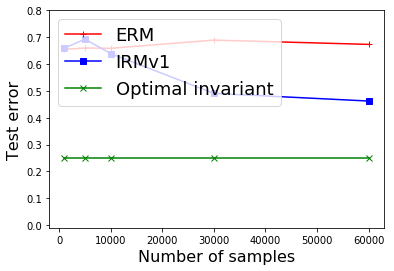

In [4]:
plt.figure()
plt.xlabel("Number of samples", fontsize=16)
plt.ylabel("Test error", fontsize=16)
plt.plot(n_tr_list, 1-ERM_model_acc_av, "-r", marker="+", label="ERM")
plt.plot(n_tr_list, 1-IRM_model_acc_av_v, "-b", marker="s",label="IRMv1")
plt.plot(n_tr_list, ideal_error, "-g", marker="x", label="Optimal invariant")
plt.legend(loc="upper left", fontsize=18)
plt.ylim(-0.01,0.8)

In [ ]:
results